# Algoritmo de Detección de actores viales

*Por: Daniela Andrea Torres Gómez*

**Objetivo:** Detectar, clasificar y localizar actores viales (Peatones, Bicicletas, Motos, Carros, Buses, Camiones) captados en video.

Para logar el objetivo se pueden dibujar rectángulos que encierren y etiqueten el objeto encontrado en cada uno de los cuadros (frames) del video.

In [48]:
# Librerias necesarias
import cv2
import time
import matplotlib.pyplot as plt
import requests

## Descarga de los archivos necesarios

Pesos del modelo, clases y archivo de configuración.

In [49]:
def download(url, name):
    """Download files"""
    r = requests.get(url, allow_redirects=True)
    open(name, 'wb').write(r.content)

In [56]:
yolo_url = 'https://pjreddie.com/media/files/yolov3.weights'
yolo_conf = 'https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg'
classes = 'https://raw.githubusercontent.com/matlab-deep-learning/Object-Detection-Using-Pretrained-YOLO-v2/main/%2Bhelper/coco-classes.txt'

In [52]:
download(url = yolo_url, name ='yolov3.weights')
download(url = yolo_conf, name ='yolov3.cfg')
download(url = classes, name ='coco-classes.txt')

## Exploración de los datos

Se describirá el número de cuadros por segundo (FPS) de cada uno de los videos analizar, el número de frames y el ancho y la altura de los mismos. Esto con el objetivo de ver si es necesario realizar un preprocesamiento de los videos, por ejemplo reduciendo la duración tal que todos queden con las mismas características.

In [4]:
folder = 'Vídeos_Prueba_DS_SIER'

In [5]:
def describe_videos(name):
    
    """Parameters of a video (.avi)
         name: Name of the video """
    
    cap = cv2.VideoCapture(f'{folder}/{name}.avi')
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # Number of frames in the video file.
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # Width of the frames in the video stream.
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # Height of the frames in the video stream.
    fps    = cap.get(cv2.CAP_PROP_FPS) # Frame rate.
    cap.release()
    
    print(f'Video {name} \n Number of frames:{length}, Width of the frames :{width}, Height of the frames :{height}, FPS:{fps}, Duration: {length/fps} s')
    return None

In [6]:
describe_videos('C1'), 
describe_videos('C2'),
describe_videos('C3'), 
describe_videos('C4'),
describe_videos('C5'),
describe_videos('C6'),

Video C1 
 Number of frames:600, Width of the frames :1280, Height of the frames :720, FPS:10.0, Duration: 60.0 s
Video C2 
 Number of frames:600, Width of the frames :1280, Height of the frames :720, FPS:10.0, Duration: 60.0 s
Video C3 
 Number of frames:600, Width of the frames :1280, Height of the frames :720, FPS:10.0, Duration: 60.0 s
Video C4 
 Number of frames:600, Width of the frames :1280, Height of the frames :720, FPS:10.0, Duration: 60.0 s
Video C5 
 Number of frames:600, Width of the frames :1280, Height of the frames :720, FPS:10.0, Duration: 60.0 s
Video C6 
 Number of frames:600, Width of the frames :1280, Height of the frames :720, FPS:10.0, Duration: 60.0 s


(None,)

### **Exploración del contenido de los videos:**  
En la siguiente celda se observa el primer frame de cada uno de los 6 videos a analizar. Los videos consisten en una vista estática a una altura media - alta de diferentes autopistas. Como hay presentes 2 o más vías en ambos sentidos, los actores viales se ven principalmente de frente o por detrás. Mientras más cerca se encuentren de la cámara, mayor es la vista aérea y es de mayor relevancia el techo del vehículo, por lo cual pueden ser confundidos con otros objetos. Igualmente, entre más cerca esté el actor vial al punto de fuga de la imagen, más tienden a parecer puntos y es más complejo detectar las características típicas de cada uno de ellos.

In [7]:
videos_name = ['C1', 'C2', 'C3','C4','C5','C6']

In [38]:
def show_first_frame(folder, videos_name):
    
    """Shows the first frame of each video"""
    
    frame_list = []
    # name of the videos 
    for name in videos_name:
        cap = cv2.VideoCapture(f'{folder}/{name}.avi')
        # captures the frames
        _, frame = cap.read()
        b,g,r = cv2.split(frame)       # get b,g,r
        frame = cv2.merge([r,g,b])     # switch it to rgb
        frame_list.append(frame)
        cap.release()
    
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3 , figsize=(18,6))
    ax1.imshow(frame_list[0])
    ax2.imshow(frame_list[1])
    ax3.imshow(frame_list[2])
    ax4.imshow(frame_list[3])
    ax5.imshow(frame_list[4])
    ax6.imshow(frame_list[5])

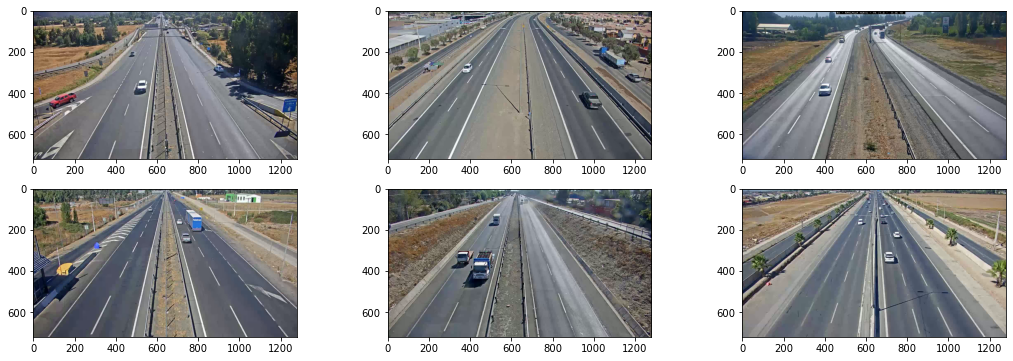

In [39]:
show_first_frame(folder, videos_name)

### ¿Qué arquitectura elegir?

De acuerdo al contenido y tipo de datos, se puede determinar qué arquitectura es la más adecuada. De las más populares están Fast RCNN, Faster RCNN y YOLO. Las dos primeras extraen regiones de la imagen y los procesan individualmente, mientras que YOLO divide la imagen en cuadrículas, las cuales se encargan de detectar los objetos. Se ha visto que esta última es mucho más rápida, dado que la imagen solo se analiza una vez. 

---

## YOLO (You Only Look Once)

Basada en la visión humana, esta arquitectura "ve" una imagen solo una vez, lo cual le permite detectar objetos de forma rápida. Fue propuesta inicialmente por Joshep Redmon en el artículo *[You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf).* El modelo YOLOv3 está entrenado en el dataset de COCO, que contiene 80 clases diferentes. Estas se pueden encontrar en el archivo *classes.txt*.

##  Arquitectura

El modelo YOLOv3 consta de los siguientes pasos:

- Se realiza una partición a la imagen de tamaño $S\times S$, lo cual arroja una rejilla de $S^{2}$ celdas.
- La celda encargada de la detección será la que contenga el centro del objeto. 
- Por cada celda se pueden detectar *B* cajas diferentes, las cuales tienen unos parámetros que consisten en las coordenadas del centro de la caja y sus dimensiones.
- *Confidence score or objectness*: Es el valor de confianza, el cual es una medida que determina si hay o no un objeto en la caja. 


<p><img alt="Colaboratory logo" height="400px" src="https://miro.medium.com/max/928/1*b0DdaTvvr9NsoGZ2MyZL0Q.jpeg" align="center" hspace="10px" vspace="0px"></p>

- De acuerdo a la cantidad de clases, se tiene la probabilidad de que que el objeto pertenezca a una clase  $P(Class_{i}|object)$. 


#### **Parámetros:**
 * B: cajas
 * $P_{o}$: Confianza.
 * $t_x$, $t_y$ : coordenadas del centro de la caja.
 * $t_w$, $t_h$ : dimensiones de la caja.
 * $p_i =  P(Class_{i}|object)$ : probabilidad de pertenecer a cierta clase.
 
 El modelo arrojará un tensor de dimensiones $S\times S \times B(5+C)$, donde C es el número de clases de el dataset de COCO (C=80). Su arquitectura es como la siguiente:
 <p><img alt="image" height="300px" src="https://media.geeksforgeeks.org/wp-content/uploads/20200305121207/YOLO_architecture.jpg" align="center" hspace="10px" vspace="0px"></p>

<img alt="image" height="40px" src="https://miro.medium.com/max/600/1*GuWOnQdxbJKWUniaiy0u1A.png" align="center" hspace="40px" vspace="0px">


La función de pérdida tiene 3 componentes.

**1. Optimizar ubicación y tamaño de la caja:**

Consta de una función de pérdida MSE para la ubicación ($\hat{x}$,$\hat{y}$) y tamaño de la caja ($\hat{h}$,$\hat{w}$). La red no optimiza directamente estos parámetros, sino que optimiza $t_x$, $t_y$, $t_w$, $t_h$. Como se ve en la siguiente figura:

<img alt="image" height="40px" src="https://bestinau.com.au/wp-content/uploads/2020/10/Bounding-Box-Representation.jpg" align="center" hspace="40px" vspace="0px">

- $p_w$ y $p_h$ son las dimensiones de cajas determinadas a priori
- $c_x$ y $c_y$ determinan la ubicación de cada celda


**2. Encontrar la categoría de un objeto:**

Determina si el objeto detectado pertence realmente a la categoría predicha.

**3. Confianza:**

Determina si se detecta o no un objeto en la caja. Para ello debe encontrar cuál es el IOU (Intersección sobre unión) del objeto, donde se determina que tan sobrepuestas están dos cajas de detección. Esto se logra dividiendo el area de intersección de dos cajas por la area total de unión de estas.

Para obtener la caja con mejor confianza, se utiliza non-max supression, que permite eliminar las cajas extras que puedan estar detectando el mismo objeto. Si hay 2 o más cajas con un IOU mayor que cierto umbral, se conserva únicamente la de mayor confianza.

<img height="300px" src="https://miro.medium.com/max/3116/1*6d_D0ySg-kOvfrzIRwHIiA.png"/>

---
## Implementación del modelo

In [14]:
Conf_threshold = 0.5 # confidence
NMS_threshold = 0.5 # Non-maximum Suppression

COLORS = [(0, 255, 0), (0, 0, 255), (255, 0, 0),
          (255, 255, 0), (255, 0, 255), (0, 255, 255)]

In [58]:
class_name = []

# classes in COCO dataset
with open('coco-classes.txt', 'r') as f:
    class_name = [cname.strip() for cname in f.readlines()]
print(class_name)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [54]:
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
net

<dnn_Net 000002AC4B861B50>

In [55]:
#net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
#net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA_FP16)

model = cv2.dnn_DetectionModel(net)
model.setInputParams(size=(416, 416), scale=1/255, swapRB=True)

In [36]:
def cv_create_video(folder, name, folder_save):
    
    """Creates the video with the detected objects"""
    
    # capture the video
    video = cv2.VideoCapture(f'{folder}/{name}.avi')
    
    starting_time = time.time()
    frame_counter = 0
    
    check, frame = video.read()
    
    # Checks if there is a video
    if check == False:
        print('Video no encontrado. Por favor ingrese un nombre válido.')
        return
    
    # Parameters to set resolutions.
    frame_width = int(video.get(3))
    frame_height = int(video.get(4))
    size = (frame_width, frame_height)
    fps = int(video.get(5))

    
    # To save the video
    result = cv2.VideoWriter(f'{folder_save}/{name}_analyze.avi', 
                             cv2.VideoWriter_fourcc(*'MJPG'), #codec 
                             fps, #FPS
                             size)
    
    # Runs while the video is open:
    while True:
        
        frame_counter += 1
        
        _, frame =  video.read()

        if frame is None:
            break
            
        # Detect the class, score and boxes in each frame 
        classes, scores, boxes = model.detect(frame, Conf_threshold, NMS_threshold)
        
        # Detect objects
        # Draws the boxes and labels of the objects in the frame
        for (classid, score, box) in zip(classes, scores, boxes):
            color = COLORS[int(classid) % len(COLORS)]

            # Labels according to the class name
            label = f"{class_name[classid]}, {score:.2f}"
            # Rectangles in each frame
            cv2.rectangle(frame, box, color, 2)
            # Text 
            cv2.putText(frame, label, (box[0], box[1]-10), cv2.FONT_HERSHEY_COMPLEX, 0.5, color, 2)

        endingTime = time.time() - starting_time
        fps = frame_counter/endingTime

        # A label with the FPS
        cv2.putText(frame, f'FPS: {fps:.3f}, Actores viales: {len(classes)}', 
                    (20, 50), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0, 255, 0), 2)
        
        # Write the frame to save a video with the results
        result.write(frame)

        # shows the frame
        cv2.imshow('frame', frame)
        
        # waitKey is required so that the image doesn’t close immediately.  
        # Press S on keyboard to stop the process
        if cv2.waitKey(1) & 0xFF == ord('s'):
            break
        

    video.release()
    result.release()
    cv2.destroyAllWindows()
    
    return True

In [32]:
# Folder to save the videos with the objects detected
folder_save = 'vid_analyze'

In [37]:
# Save the videos 
for name in videos_name:
    cv_create_video(folder, name, folder_save)

## Resultados

Se muestra el primer frame de cada uno de los videos ya testeados.

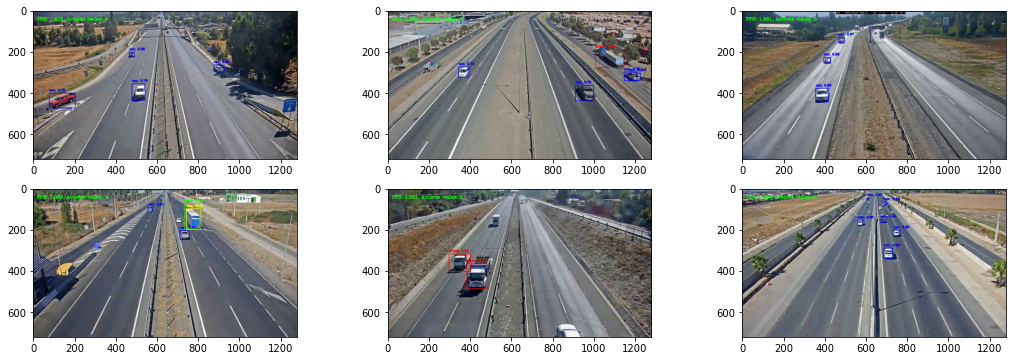

In [41]:
video_name_analyze =  ['C1_analyze', 'C2_analyze', 'C3_analyze','C4_analyze','C5_analyze','C6_analyze']
show_first_frame(folder_save, video_name_analyze) 